# Chapter 1: Business Understanding
## Introduction 
  Establishing a clear understanding of the problem space is crucial. This chapter outlines the objectives and goals of the classification task, framing the project from a business and real-world impact perspective.
  
  In this chapter, we will define the core problem: how to accurately classify handwritten digits in a way that accounts for inconsistencies in human handwriting. We will identify the business goal (e.g., high-accuracy digit recognition for use in automated form reading or postal code sorting systems) and translate it into a data science goal (e.g., building a robust, validated classifier). Key constraints such as accuracy thresholds, interoperability, and handling of noisy inputs will be explored.

## Business Goals
  Setting out clear and measurable business goals allows us to keep the project on track, preventing the development and creation of unnecessary features (avoid feature creep).
###
  - BG01: Achieve at least 60% accuracy in digit classification on the MNIST test dataset by the end of the development phase.
  - BG02: Reduce misclassification of ambiguous digits (e.g. 1 vs 7, 5 vs 6, 4 vs 9) by 20%, for use in environments where data clarity is not guaranteed.
## Functional Requirements
  Functional requirements are build with each business goal in mind. I see functional requirements as a check list of features that the system needs to implement before we can say that the system can achieve its linked business goal.
###
  - FR01: (BG01) - Preprocess all images to normalize contrast and scale pixel intensities, improving the model's ability to detect digits consistently.
  - FR02: (BG02) - Implement a validation loop using **(possibly)** cross-validation techniques to measure performance during training.
  - FR03: (BG03) - Integrate data augmentation (e.g. rotation, scaling, noise injection) into the training pipeline to simulate real-world handwriting variations.
  - FR04: (BG04): - Log and evaluate classification errors by digit types to identify confusion patterns between specific digits. 
## Conclusion 
  This step sets the foundation for the work to come. It ensures that each following step aligns with the business goals and requirements rather than chasing technical complexity for its own sake. Without a clear understanding of what the business actually wants to achieve, it would be impossible to measure and determine if our resulting model is effective at solving the problem we set out to solve.

# Chapter 2: Data Understanding
## Introduction
  Before starting any development work on the model we need to evaluate our data and identify any key problem areas that could be present in the dataset. Firstly, a deeper drive into some images provided in the MNIST dataset allows for a more informed preprocessing and modelling choices in the following steps. With the hope being the more effort that is placed into this step will result in a better utilization of our time in later steps.
### Deep Dive
  The MNIST dataset consists of 70,000 images in total, with 60,000 used for training and 10,000 reserved for testing (assuming cross-validation is used). Each image is a 28x28 pixel grayscale representation of a single digit, ranging from 0 to 9. Additional considerations will need to be made for handling written variations of humans when writing these numbers. For example: A "4" written with a looping curve might resemble a "9" to our model. Another would be a wide "1" vs a narrow "7" has a high chance of confusing our model. Examples like these are predicted to cause the larges drop in our models performance.

### Functional Requirements
  To support FR01, a review of pixel intensity distributions across a sample of the dataset will be carried out. This could helps in understanding the baseline variances in brightness and contract, this can be done though processes like Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE). No preprocessing is being carries out on the dataset at the current time.
  
  To support FR03, a review of number frequency can be carried our to identify common and uncommon numbers int hte dataset. FR03 can benefit from this early analysis by allowing for more targeted data augmentation in the hops of generating more variations in least common numbers in the data set. Increasing the neutrality of the final trained model by providing it with a more even distribution of classes to train on.

## Conclusion
  In summary, this chapter aims to not only prepare the project for the data preparation step. It also links all understanding of the dataset back to the function requirements and the business goals. Understanding the data is important, yes. But for this chapter it is also important to understand the data from the perspective of meeting both the functional requirements and the business goals. Orientating the projects perspective this way helps focus on areas which are only relevant to meeting the business goals of the project, prevent diversions into areas that are not critical for its success.

Value Count Table:
Digit
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64


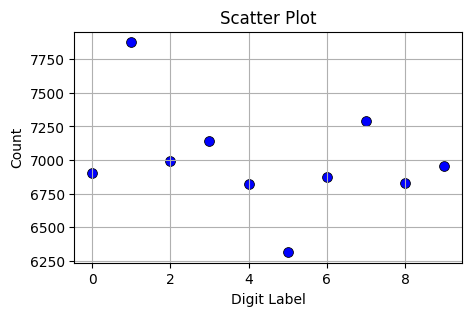

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from Scripts.image_data_container import ImageData

# Load the dataset
dataArrays = np.load("Imports/mnist_combined.npz")
imageDataObject = dataArrays
loadedImages = dataArrays['images']
loadedLables = dataArrays['labels']
# imageDataObject = ImageData(dataArrays)

# Reshape images to shape (number of samples, 1, 28*28) <- 28^2 since each image is 28*28
loadedImages = loadedImages.reshape(-1, 1, 784)


# Extract labels and convert to a DataFrame for convenience
df = pd.DataFrame(loadedLables, columns=['Digit'])

# Create a value count table
value_counts = df['Digit'].value_counts().sort_index()
print("Value Count Table:")
print(value_counts)

x = value_counts.index
y = value_counts.values

# Create the Scatter Plot
plt.figure(figsize=(5, 3))
sns.scatterplot(x=x, y=y, s=50, color='blue', edgecolor='black')
plt.title("Scatter Plot")
plt.xlabel("Digit Label")
plt.ylabel("Count")
plt.grid(True)
plt.show()

## Descriptive Statistics and Distribution
  Preliminary values count analysis revealed that the digit "1" occurs far more often then all other numbers in the data set, while the digit "5" is the lease common. This process was achieved though a simple count of lables within the dataset. This imbalance, while not drastic, is significant enough to consider when planning strategies for model training, evaluation, and sampling.
  
  A feather visual inspection of the dataset was carried out using a scatter plot to help quickly identify and confirm the imbalance that was recorded. Notably.

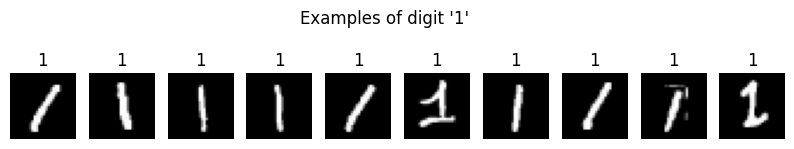

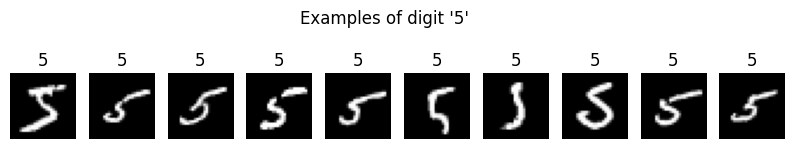

In [2]:
from collections import Counter
import matplotlib.pyplot as plt

# Count occurrences of each digit
label_counts = Counter(loadedLables)

# Get most and least common digit
most_common = label_counts.most_common(1)[0][0]
least_common = label_counts.most_common()[-1][0]

def plot_digit_examples(digit, n=10):
    idxs = np.where(loadedLables== digit)[0][:n]
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i + 1)
        # reshape the 1D 784 array back into its 28 by 28 pixel grid image
        imageToShow = loadedImages[idx].reshape(28,28)
        plt.imshow(imageToShow, cmap='gray')
        plt.axis('off')
        plt.title(f"{digit}")
    plt.suptitle(f"Examples of digit '{digit}'")
    plt.show()

plot_digit_examples(most_common)
plot_digit_examples(least_common)


## Visual Inspection of Most and Least Common Numbers
  Notably, even among the more abundant digits like "1", writing styles varied considerably; from straight vertical lines, to slightly curved or more cursive like in nature.

Testing: 50 iterations


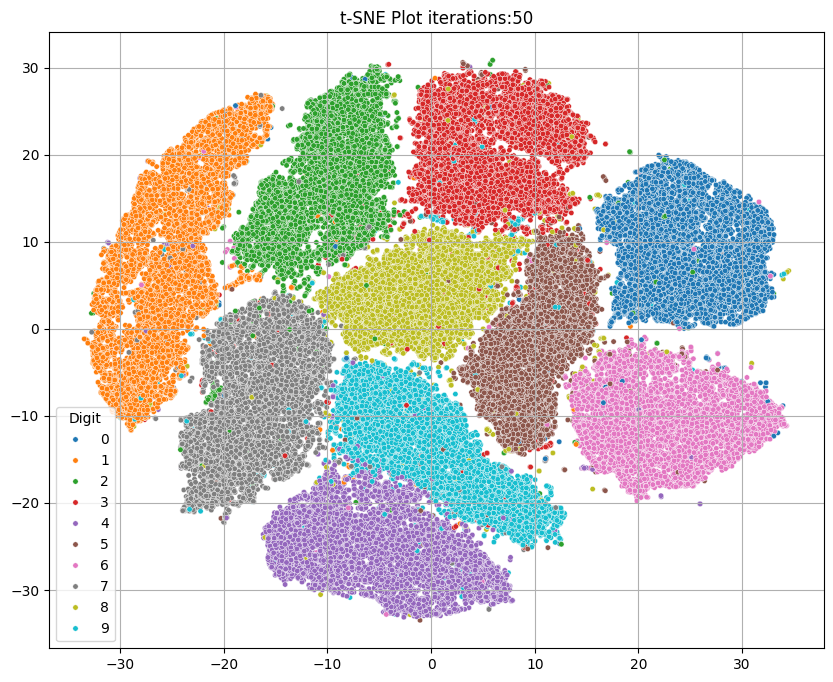

In [3]:
# %pip install openTSNE # <-- interesting
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from openTSNE import TSNE

# Flatten the images for PCA/t-SNE
flattened_images = loadedImages.reshape(len(loadedImages), -1)

# Run PCA to reduce dimensionality (retain 50 components first)
pca = PCA(n_components=50, random_state=42)
pca_result = pca.fit_transform(flattened_images)


def TSNERun(numberOfRuns):
  # Then run t-SNE on PCA result for better visualization
  tsne = TSNE(
    n_components=2,
    perplexity=30,
    metric="euclidean",
    n_iter=numberOfRuns,
    random_state=42
    )
  tsne_result = tsne.fit(pca_result)

  # Plot the t-SNE result
  plt.figure(figsize=(10, 8))
  sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=loadedLables, palette='tab10', legend='full', s=15)
  plt.title(f"t-SNE Plot iterations:{numberOfRuns}")
  plt.legend(title='Digit')
  plt.grid(True)
  plt.show()


# comparison of different t-SNE iterations.
print("Testing: 50 iterations")
TSNERun(50)
# print("Testing: 25 iterations")
# TSNERun(25)
# print("Testing: 5 iterations")
# TSNERun(5)
# print("Testing: 2 iterations")
# TSNERun(2)
# print("Testing: 1 iteration")
# TSNERun(1)


## Variance Exploration Using PCA and t-SNE
  To better understand the underlying variances in handwriting styles, dimensionality reduction was employed. Principal Component Analysis (PCA) was first applied to reduce the dataset to its 50 most informative components. While feature testing can be carried out to better fine tune this value, a large number of online sources are recommending 50 as a decent starting point for preserving as much data integrity as possible. 
  
  The t-Distributed Stochastic Neighbor Embedding (t-SNE) algorithm, whilst horribly slow resulting in the use of an external library OpenTSNE to speed up performance, helped provide further insight into the clustering behavior of different digit classes. Different iteration counts where tested and whilst clustering did occur from as little as 5 iterations, more uniform and "cleaner" separation only began to form from iterations value greater than 20. However, values over 75 did not seam to have a noticeable impact of number clustering. 
  Number clustering did not reach 100% even after iteration values of over 500 where tested with no noticeable changes being overserver. This is like do to writing styles and pixel values numbers int the data set, resulting in their classifications being similar to other digits with the the frore cluster.

## Summary of Understanding
  The most common number identified within the dataset was "1" with the lease common bing "5". variance observations highlighted high intra-class variability through the used of t-SNE, with no significant structural clustering happening until around 5 iterations where reached.

  These findings help reinforce the importance of the preprocessing that that is to come. It also helps with identifying areas of importance to focus on when handling the preprocessing step of the project.

# Chapter 3: Data Preparation
## Introduction
  This phase of the CRISP-DM process is where the raw dataset will be modified and transformed into a structured format that is ready to be given to the model training part of the CRISP-DM cycle in the next part.
  In order to meet the defined functional requirements, the data preparation will go through 3 phases.
## Preparations Steps
  yes I just realized I have been calling it model preprocessing lets hope I remember to fix that XD

  1. Normalization and Scaling (FR01): Standardizing the pixel values ensures consistent contrast between filled pixels within the number and the background. Doing so also helps reduce the size of the data with each image from 28*28*(0-255) to 28*28*(0-1).
  2. Augmentations (FR03): introducing controlled variations like rotation, zoom, and noise injection to simulate the inconsistencies of writing styles as well as providing more variations on numbers with lower number of entries within the dataset can help remove bias from the training model. Furthermore, providing a since of randomness to the training set can help make the final trained model more resilient to real world inputs.
  3. Training nd Testing Data Preparations: Original and augmented images will be combined and split into Tracing-Testing-Validation datasets, allow for model validations to be carried out of images that are not present in the training data.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
from scipy.ndimage import rotate, zoom
from tqdm import tqdm

#Step 1: Normalize pixel intensities (FR01)
scaler = MinMaxScaler()
normalizedImages = scaler.fit_transform(loadedImages[:, 0])
normalizedImages = normalizedImages.reshape(-1, 1, 784)

#Step 2: Data Augmentation (FR03)
def augment_image(image):
    image = image.reshape(28, 28)
    aug_images = []
    # Random rotation
    aug_images.append(rotate(image, angle=random.uniform(-15, 15), reshape=False))
    # Random zoom
    zoom_factor = random.uniform(0.9, 1.1)
    zoomedImage = zoom(image, zoom_factor)
    # Resize zoom back to 28x28
    hight, width = zoomedImage.shape
    if hight > 28:
        # Crop
        start_h = (hight - 28) // 2
        start_w = (width - 28) // 2
        zoomedImage = zoomedImage[start_h:start_h+28, start_w:start_w+28]
    else:
        # Pad
        pad_h = (28 - hight) // 2
        pad_w = (28 - width) // 2
        zoomedImage = np.pad(zoomedImage, ((pad_h, 28 - hight - pad_h), (pad_w, 28 - width- pad_w)), mode='constant')

    aug_images.append(zoomedImage)
    # Noise injection
    noise = np.random.normal(0, 0.05, image.shape)
    aug_images.append(np.clip(image + noise, 0., 1.))
    return [img.reshape(1, 784) for img in aug_images]

augmentedImages = []
augmentedLabels = []
for img, lbl in tqdm(zip(normalizedImages, loadedLables), "Processing images and lables...", total=70000):
    augmentedImages.extend(augment_image(img))
    augmentedLabels.extend([lbl] * 3)  # Three augmentations per image
print("Done... \n Saving images and lables to arrays")
# Combine original and augmented data
finalImages = np.concatenate((normalizedImages, np.array(augmentedImages)), axis=0)
finalLabels = np.concatenate((loadedLables, np.array(augmentedLabels)), axis=0)

# Step 3: Train-Test-Validation Split 
X_temp, X_test, y_temp, y_test = train_test_split(finalImages, finalLabels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2
X_train = X_train.reshape(X_train.shape[0],-1)
X_val = X_val.reshape((X_val.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))
# Final shapes
print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Processing images and lables...: 100%|██████████| 70000/70000 [00:20<00:00, 3362.03it/s]


Done... 
 Saving images and lables to arrays
Train shape: (168000, 784), Validation shape: (56000, 784), Test shape: (56000, 784)


## Conclusion
  During the model preparation step, images where transformed into a state that is ready to pass onto model training in the next step. Normalization was carried out to contrast the intensities between filled pixels and the background of each number image. Data size of each image was also reduce by normalizing each pixel value from between 0 to 255 to 0 and 1, allowing the completions of FR01.
  Basic image augmentation in the form of random rotation by +- 15 degrees and by zooming images by a random zoom factor between a 90% and 110%. Zoomed images had to be checked to ensure they maintained the correct 28x28 pixel grid size for uniformity. The application of random rotation, random scaling, and finlay random noise injection allowed for the completion of FR03.
  
  The final results where then split up and stored into three different datasets (Training, Testing, Validations), which will be used in the next step of CRISP-DM.

# Chapter 4: Modeling
## Introduction
  Moving onto the model step of the CRISP-DM cycle will see migration from theory and data understanding to wards making using of the data that was processed and prepared in the previous step. The aim here is not to only build classifiers that perform well numerically, but to gain a wide range of understanding by implementing a large range of different model candidates. Most of the code in this section will make heavy use of pre-made libraries and functions to speed up development, as the aim here is not to re-invent the wheel.
  As we have seen and tested in the last steps, the MNIST dataset varies in handwriting styles. It is important to keep this in mind as numbers can be very easily mis-classified as others due to this large variation in writing styles. Though consideration needs to be taking to account for this, getting a model that results in a 99% accuracy score is not the goal here. Linking back to the set business goal in the 1st chapter, we are aiming for around a 60%-70% accuracy. I believe that this value is sufficient enough to gain a decent grasp of how each model works, allowing for reenable conclusions to be drawn from each experiment.
## Models

### Principal Component Analysis (PCA)
  Having already used and implemented PCA's in the Data Understanding step earlier in the CRISP-DM cycle, this is where the start of this chapter is going to focus on. The main benefit to starting with a PCA is that it will reduce the current 784  dimensions that the image data is currently in, and reduce it down to around 50. Provided the same settings are used as in the Data Understanding phase. In doing so, we can greatly reduce the number of dimensions and thus the complexity of the data the other models candidates will have to process. As show before, a lot of the data inside each image contains very little if any useful information. This is data that can be removed or consolidated to help boost model performance and reduce model training time.

  The reduced data can also be fed into later model candidates to reduce training time and improve their overall performance.

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os


# This can get a little heavy, so we are going to save the outputs to a csv file.
export_file_path = "Exports/pca_outputs"
os.makedirs(export_file_path, exist_ok=True)

print("Starting PCA...")
# Standardizing the dataset before PCA to ensure each feature contributes equally
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Applying the same transformation to the test set to maintain consistency in feature space
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
 
def ProcessPCA(number_components=0.5):
  # Choosing 95% variance retention to reduce dimensionality while preserving most of the data's structure
  print(f"Processing PCA with target relevance of {number_components}")
  print(f"{X_train.shape[1]} Dimensions before PCA")
  pca = PCA(n_components=number_components, svd_solver='full')
  X_train_pca = pca.fit_transform(X_scaled)
  print(f"{X_train_pca.shape[1]} Dimensions after PCA \n Processing...")

  print("Done, writing to csv file...")
  # Process the PCA function and save the result to a csv file.
  pca_df = pd.DataFrame(X_train_pca)
  pca_df['labels'] = y_train
  pca_df.to_csv(f"{export_file_path}/pca_transformed_data_{number_components}.csv", index=False)
  # Also save the explained variance ratio for plotting later
  explained_variance_df = pd.DataFrame({'ExplainedVariance': pca.explained_variance_ratio_})
  explained_variance_df.to_csv(f'{export_file_path}/explained_variance_{number_components}.csv', index=False)
  print("Done!")

ProcessPCA(0.5)
# ProcessPCA(0.8)
# ProcessPCA(0.95)

Starting PCA...
Processing PCA with target relevance of 0.5
784 Dimensions before PCA
37 Dimensions after PCA 
 Processing...
Done, writing to csv file...
Done!


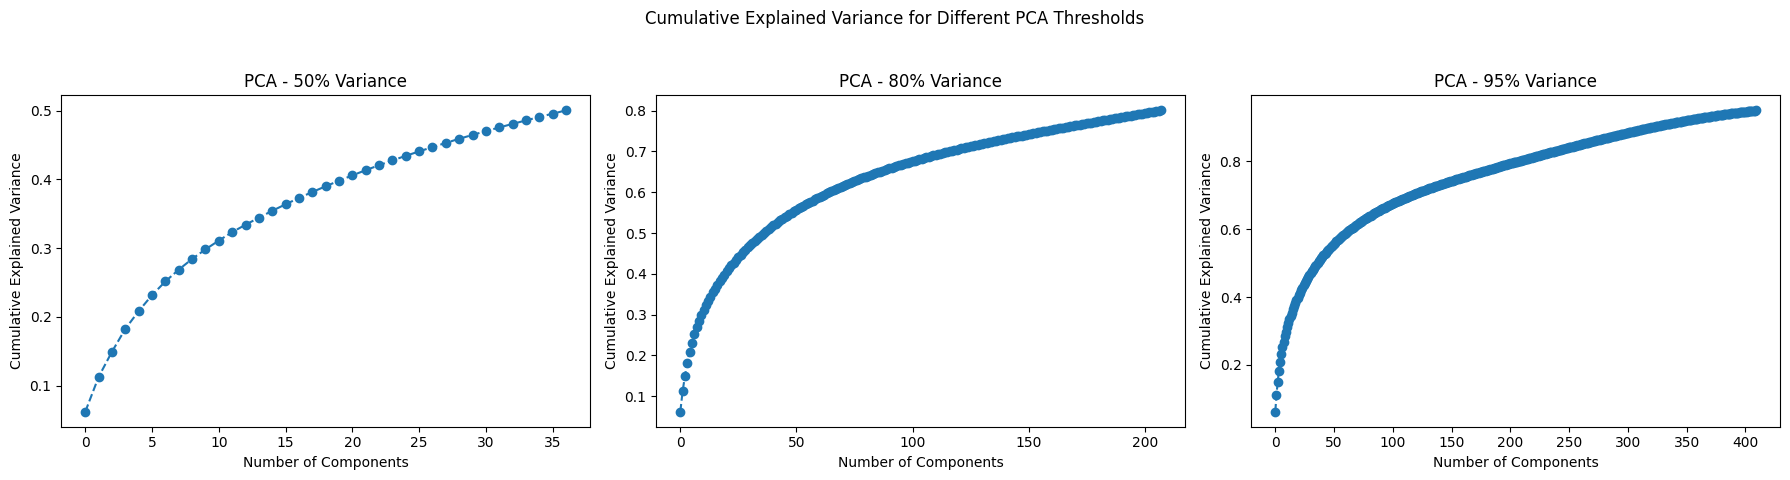

Finished PCA


In [6]:
# We almost never need to run the above multiple time, we can just run this part once the csv files are created.

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Cumulative Explained Variance for Different PCA Thresholds')

# 50% Variance
loaded_explained_variance = pd.read_csv(f"{export_file_path}/explained_variance_{0.5}.csv")
axes[0].plot(np.cumsum(loaded_explained_variance['ExplainedVariance']), marker='o', linestyle='--')
axes[0].set_title('PCA - 50% Variance')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Cumulative Explained Variance')

# 80% Variance
loaded_explained_variance = pd.read_csv(f"{export_file_path}/explained_variance_{0.8}.csv")
axes[1].plot(np.cumsum(loaded_explained_variance['ExplainedVariance']), marker='o', linestyle='--')
axes[1].set_title('PCA - 80% Variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')

# 95% Variance
loaded_explained_variance = pd.read_csv(f"{export_file_path}/explained_variance_{0.95}.csv")
axes[2].plot(np.cumsum(loaded_explained_variance['ExplainedVariance']), marker='o', linestyle='--')
axes[2].set_title('PCA - 95% Variance')
axes[2].set_xlabel('Number of Components')
axes[2].set_ylabel('Cumulative Explained Variance')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Finished PCA")

#### Principle Component Analysis Conclusion (PCA)
  The PCA transformation significantly reduces the dimensionality of the MNIST dataset—from 784 original features to a more compact set of as little as 37 dimensions while still retaining the the majority of the information that will be reliant moving forward. This is a crucial preprocessing step, not only because it streamlines computation for subsequent models but also because it suppresses noise and redundancy. The plot above confirms that a relatively small number of principal components capture the majority of the dataset’s informational content, even after discarding around 95.28% of the original data.

### Support Vector Machines (SVM)
  Support Vector Machine (SVM) is useful when solving classification problems with high dimensionality. In this project, the SVM is applied after the PCA transformation has already reduced the dimensionality of the data. By targeting a n_component of 50% in the PCA of the explained variance, the dimensionality reduction steps help keep training times low by compressing redundant information and preserving the core structure required for effective classification. This processing step no only reduces the risk of overfilling but also helps improve computational efficiency during training and evaluation. In the following implementation, the Radial Basis Function (RBF) kernel is used as a starting point due to strengths in non-linear decision boundaries. 

In [12]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load PCA-transformed data 
pca_data = pd.read_csv(f"{export_file_path}/pca_transformed_data_0.5.csv")

# Split features and labels
X = pca_data.drop('labels', axis=1)
y = pca_data['labels']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reduce data for faster training
X_small = X_train.sample(frac=0.5, random_state=42)
y_small = y_train.loc[X_small.index]

# Ensure output directory exists
results_dir = "Exports/svm_results"
os.makedirs(results_dir, exist_ok=True)

# Define SVM configurations
svm_configs = {
    "rbf": {
        "model": SVC(kernel='rbf'),
        "params": {"C": [1, 10], "gamma": ['scale', 0.01]}
    },
    "poly": {
        "model": SVC(kernel='poly'),
        "params": {"C": [1, 10], "degree": [2, 3], "gamma": ['scale']}
    }
}

# Train and evaluate each SVM
for name, config in svm_configs.items():
    print(f"Training {name} kernel SVM...")
    grid = GridSearchCV(config["model"], config["params"], cv=3, n_jobs=-1, verbose=3, scoring='f1_macro')
    grid.fit(X_small, y_small)

    # Best model evaluation
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True)
    matrix = confusion_matrix(y_test, y_pred)

    # Save classification report and confusion matrix
    pd.DataFrame(report).transpose().to_csv(f"{results_dir}/svm_{name}_report.csv")
    pd.DataFrame(matrix).to_csv(f"{results_dir}/svm_{name}_confusion_matrix.csv")

    # Save the trained model
    joblib.dump(best_model, f"{results_dir}/svm_{name}_model.pkl")

    # Basic heatmap plot for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix - SVM ({name} kernel)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"{results_dir}/svm_{name}_confusion_matrix.png")
    plt.close()
    print(f"{name} kernel SVM results and plot saved.")

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Final SVM F1 (macro): {f1_macro}")

Training rbf kernel SVM...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 2/3] END .................C=10, gamma=scale;, score=0.972 total time= 1.4min
[CV 1/3] END .................C=10, gamma=scale;, score=0.975 total time= 1.5min
[CV 3/3] END .................C=10, gamma=scale;, score=0.974 total time= 1.6min
[CV 1/3] END ..................C=1, gamma=scale;, score=0.964 total time= 1.8min
[CV 2/3] END ..................C=1, gamma=scale;, score=0.963 total time= 1.8min
[CV 3/3] END ..................C=1, gamma=scale;, score=0.962 total time= 1.8min
[CV 1/3] END ..................C=10, gamma=0.01;, score=0.956 total time= 3.0min
[CV 2/3] END ..................C=10, gamma=0.01;, score=0.957 total time= 3.1min
[CV 3/3] END ...................C=1, gamma=0.01;, score=0.952 total time= 3.1min
[CV 1/3] END ...................C=1, gamma=0.01;, score=0.952 total time= 3.2min
[CV 2/3] END ...................C=1, gamma=0.01;, score=0.952 total time= 3.2min
[CV 3/3] END .........

#### Support Vector Machines Conclusion
  Support Vector Machine (SVM) delivered an F1 score of 0.972, which is by far the best out of all models that is covered in this project, however there are some concerns. The most immediate concern is that an F1 score that high runs a very possible risk of being over-fitted, especially when the accuracy score of the model does not deviate by any noticeable amounts during training. Future research will need to be performed before an F1 score that high can be truly trusted.

  The major drawback to using this model is its extremely long training time. Even after reducing the training dataset from the original 1/3rd to half that! The model still takes over 15 minutes to complete its fitting. Furthermore the resultant accuracy score does not make any significant improvements on other models that are tested in this project. The training time to what is being delivered could also be an indicator that the model may be overly complex for the task at hand, especially after also reducing the dimensionality of the input datasets with PCA, from the original 784 dimensions down to ~34 dimensions. There is currently very little interest in using such a heavy model moving forward.

  Looking at the confusion matrix, several digit classes (such as 0, 1, and 4) are being predicted with a strong precision and recall, as reflected in their dense diagonal entries. However, there are still non-negligible misclassifications, especially for digits like 3 and 5. For instance, the digit 3 is occasionally confused with 5, 8, and 9, which is an expected outcome and a concern raised before beginning model selection. Misclassifications, though relatively sparse, still signal that there is room for improvement and that the model is not fervently robust across all classes. However, at the current moment, the extremely long training times for the model makes rapid iteration difficult, time consuming and painful. 

  In summary, while the performance metrics might suggest success, the high training time and suspiciously strong F1 score indicates the need for caution. An are that might be good to look into would be seeing if gradient descent



### k-Nearest Neighbors (k-NN)
K-Nearest Neighbors (k-NN) is an instance based learning algorithm that operates on the principle that data points with similar characteristics tend to exist near each other, a principle that Chapter 2's Variance Exploration Using PCA and t-SNE helps backup. When presented with a new data instance, a new input, the algorithm identifies the k closest training examples based on a distance metric such as euclidean distance and assigns the most common class among those neighbors to the new input. This "identification by comicality" can lead to a high risk of miss classifying new data inputs, as can also be seen in chapter 2 when t-SNE is used image pixel values do result in some degree to inherent error.
The goal with implementing k-NN is that it will offer a way better handle visual similarities across different handwriting styles. For example, a poorly written "4" might still cluster near other clearer "4"s in the feature space if the right features and distance metrics are used.

In [10]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Load PCA-transformed data
pca_data = pd.read_csv(f"{export_file_path}/pca_transformed_data_0.5.csv")

# Split features and labels
X = pca_data.drop('labels', axis=1)
y = pca_data['labels']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure output directory exists
results_dir = "Exports/k-NN_results"
os.makedirs(results_dir, exist_ok=True)

# Define k-NN classifier and grid search parameters
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}

# Perform Grid Search with 5-fold Cross Validation
grid_search = GridSearchCV(knn, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=3)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
matrix = confusion_matrix(y_test, y_pred)

pd.DataFrame(report).transpose().to_csv(f"{results_dir}/k-NN_report.csv")
pd.DataFrame(matrix).transpose().to_csv(f"{results_dir}/k-NN_confusion_matrix.csv")

# save the train model to a pickle file
joblib.dump(best_knn, f"{results_dir}/k-nn_model.pkl")

# Basic heatmap plot for confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title(f'Confusion Matrix - k-NN')
plt.xlabel('predicted')
plt.ylabel('Actual')
plt.savefig(f"{results_dir}/k-NN_confusion_matrix.png")
plt.close()
plt.show()

# print f1 score to be used for later evaluation.

f1_macro= f1_score(y_test, y_pred, average='macro')
print(f"k-NN F1 (macro): {f1_macro}")


print("Saved k-NN")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV 3/3] END ...n_neighbors=3, weights=distance;, score=0.958 total time=  36.6s
[CV 2/3] END ...n_neighbors=3, weights=distance;, score=0.960 total time=  36.6s
[CV 2/3] END ...n_neighbors=5, weights=distance;, score=0.959 total time=  36.9s
[CV 1/3] END ...n_neighbors=3, weights=distance;, score=0.960 total time=  37.5s
[CV 1/3] END ...n_neighbors=5, weights=distance;, score=0.960 total time=  37.7s
[CV 2/3] END ....n_neighbors=3, weights=uniform;, score=0.956 total time=  37.8s
[CV 3/3] END ...n_neighbors=5, weights=distance;, score=0.959 total time=  37.9s
[CV 3/3] END ....n_neighbors=3, weights=uniform;, score=0.955 total time=  38.7s
[CV 2/3] END ....n_neighbors=5, weights=uniform;, score=0.955 total time=  38.8s
[CV 1/3] END ....n_neighbors=3, weights=uniform;, score=0.957 total time=  39.1s
[CV 1/3] END ....n_neighbors=5, weights=uniform;, score=0.956 total time=  39.3s
[CV 3/3] END ....n_neighbors=5, weights=uniform;,

#### k-Nearest Neighbors (k-NN) Conclusion
  The k-Nearest Neighbors algorithm yielded a surprisingly high F1 score of 0.968 when applied to a third of the dataset. The model was able to complete its fitting process in under two minutes, demonstrating an impressive level of efficiency for a traditional distance-based method. However, an F1 score exceeding 95% raises some important considerations.

  With online material stating that k-NN is known for performing well on small-scale image recognition tasks, such a high score on noisy, highly variable handwritten numbers is somewhat suspicious. This suggests the possibility of over-fitting, despite cross-validation efforts. Though the current cross-validation value currently being used is on the low end of what is recommended in the documentation for the GridSearchCV method, default should be 5 but it was lowered to 3 in order to improve model training times.

  As a result, further testing should be carried out on additional validation sets, perhaps even across subsets with intentionally degraded samples, such as turning up the noise injection or adding extreme levels or rotation to random number images? However, in the context of the time-constrained project, k-NN currently stands out as a strong early candidate when compared to other models tested such as SVM.

  Looking into the model's confusion matrix can help reveal a few areas of concern. For instance, digit 5 is often misclassified as 8, with 52 instances of this happening inside the matrix. Furthermore, digits like 4 frequently get misread as 9. These patterns were expected at the beginning, but it would have been nicer to have them occur less often. These patterns are most likely caused by the un uniform nation of different handwriting styles. Better data preprocessing could be carried out to help reduce these variations more. Or image compression could be used to help normalize the pixel values of each image better might also be an area to research further into. While disappointing as it may seem, these misclassifications were not widespread enough to significantly impair the overall F1 score.

  In conclusion, k-NN offers a solid baseline and performs well under computational constraints while flagging key interoperability advantages. However, it is a surprisingly high performance metric that requires further validation before the model can be confidently relied upon moving forward and steps should be taken to either prove the validity of the high F1 score, or rebind the input parameters more. 


### Data Loading and Preparation
The PCA-transformed features are loaded from pca_features.csv.
The dataset is split into training (80%) and testing (20%) sets using train_test_split().
### Training the SVM Model
An SVM (Support Vector Machine) classifier is initialized with a linear kernel (SVC(kernel='linear')).
The model is trained on the training set (X_train, y_train) using svm.fit().
The SVM finds the optimal hyperplane that separates different digit classes in the feature space.
### Prediction and Evaluation
The trained SVM model predicts digit labels for the test set (X_test).
Accuracy is calculated to measure overall correctness.
### Visualization of Results
Confusion Matrix Heatmap:
Displays where the model misclassified digits.
A perfect model would have values only on the diagonal (true positive matches).
Accuracy Bar Chart:
Shows the overall accuracy of the SVM model in a simple, visual format.

# Chapter 5: Final Evaluation & Conclusion.

Both the SVM and the k-NN models demonstrate their strong classification abilities. With each model scoring a very high F1 score of over 95%. Whilst these scores are very impressive, both have to be called into question as there is a high likelihood that both models are overfit for the data provided and it is not clear how ether would react when given data in the future that is not part of the initial training set. Future analysis should be performed on both using techniques such as gradient descent to test a wide range of input settings before we can fully trust either model on their F1 score alone. Furthermore, differences begin to emerge once the training duration and computational overhead are brought into consideration.

Support Vector Machine (SVM) produces the highest F1 score at 97%, but the results must be called into question. The consistency of its accuracy score during the fitting process gives rise to suspicion of possible overfitting, especially when taking into account the heavy application of Principal Component Analysis (PCA) to reduce dimensionality. Even with a significantly trimmed dataset, SVM’s training time exceeded 15 minutes. This makes rapid iteration and tweaking of its training parameters not only time-consuming but also detrimental to project efficiency, particularly when operating under tight deadlines.  While its confusion matrix indicates excellent precision for numbers/ digits like 0, 1, and 4, recurring misclassifications between similar-looking digits such as 3 and 5 remain a concern. The model appears overly complex for a task that could arguably be solved with a light, more agile approach.

In contrast, the k-NN model achieved an F1 score of 96.8%. While this value is slightly lower compared to the SVM model. This came at a fraction of the training time for the mode. Training was completed in under two minutes, making the model much more attractive for future tuning of its training parameters. The quick turn around between training and model fitting is something that is not realistic for SVM at the current time. Furthermore it also raises the question of SVM being overly complex for the current problem. 
k-NN’s confusion matrix does show a similar pattern of misclassification, such as 5 being mistaken for 8, and 4 being mistaken for 9, but not to a degree that is significantly harmful to the overall accuracy of the model. While the high performance from k-NN is indeed promising, an accuracy of over 95% must be called into question, especially for the surface level testing that was performed throughout the project. 

The use of a lower then recommended cross-validation fold count (3 instead of 5 as stated in the documentation for GridSearchCV) in both models may have biased the performance metrics, suggesting that future testing is needed. Especially using validation sets infused with aggressive data augmentations such as increased noise and rotation, inline with FR03 should be considered for future iterations of the CRISP-DM cycle.

Tying this evaluation back to our functional requirements, both models have helped meet FR01 and FR02 by utilizing / leveraging normalized input data and consistent validations loops. The incorporation of augmentation strategies such as rotation, zoom, and noise injection helps us meet our FR03. While the analysis of confusion matrices as outlined in FR04 has highlighted where future improvements in robustness are required.

Of the two, k-NN currently aligns best with the project’s needs, offering the highest level of performance and manageable computational demands. Thai make is a stronger candidate for future CRISP-DM cycles.


Looking ahead, future work should involve iterative value modifications using techniques such as gradient descent, particularly as a way to optimize hyperparameter or input features in a more continuous, data-driven manner. Though traditionally gradient descent I believe at the very least its methodology and techniques could be applied in a hybrid technique or used in pre-processing steps. For SVM, integration of gradient-based optimization could also aid in refining model complexity and reducing training time. If successful, future development and experimentation would be more appealing for this high complexity model.

In concussion, based on my findings and testing during this project, k-NN currently stands as the preferred model for future development and testing. This is not only due to the much faster training speed of the model, but also the high (if questionable) accuracy.  Regardless of which model is best for future CRISP-DM cycles, the primary outcome remains the same.  Further testing, however, remains essential to validate these promising results under a broader range of data conditions.

# 6. References
## Image pre-processing
[1]“Gaussian Blur - an overview | ScienceDirect Topics,” www.sciencedirect.com. https://www.sciencedirect.com/topics/engineering/gaussian-blur

[2]“Python | Thresholding techniques using OpenCV | Set-1 (Simple Thresholding) - GeeksforGeeks,” GeeksforGeeks, May 06, 2019. https://www.geeksforgeeks.org/python-thresholding-techniques-using-opencv-set-1-simple-thresholding/
‌

[3]F. Daghero, D. J. Pagliari, and M. Poncino, “Energy-efficient deep learning inference on edge devices,” Advances in Computers, pp. 247–301, 2021, doi: https://doi.org/10.1016/bs.adcom.2020.07.002.

## Histogram of Gradients
[4]UCF CRCV, “Lecture 9.3: Features [Histogram of Gradients] [HOG],” YouTube, Jul. 26, 2023. https://www.youtube.com/watch?v=92-NaIdIrEs (accessed Mar. 15, 2025).
‌‌

[5]R. Manavalan, “Automatic identification of diseases in grains crops through computational approaches: A review,” Computers and Electronics in Agriculture, vol. 178, p. 105802, Nov. 2020, doi: https://doi.org/10.1016/j.compag.2020.105802.


[6]Skillcate AI, “HOG Intuition | Simple Explanation | Feature Descriptor & Engineering,” YouTube, Jun. 13, 2021. https://www.youtube.com/watch?v=5nZGnYPyKLU (accessed Mar. 15, 2025).

## Sobel Filter
[7]“Sobel Filter - an overview | ScienceDirect Topics,” www.sciencedirect.com. https://www.sciencedirect.com/topics/computer-science/sobel-filter

## Dimensionality reduction
[8]C. Angermann and M. Haltmeier, “Deep structure learning using feature extraction in trained projection space,” Computers & Electrical Engineering, vol. 92, p. 107097, Jun. 2021, doi: https://doi.org/10.1016/j.compeleceng.2021.107097.
‌
##  SVM
[9]A. Navlani, “Scikit-learn SVM Tutorial with Python (Support Vector Machines),” www.datacamp.com, Dec. 2019. https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python


[10]V. N. Vapnik, “An overview of statistical learning theory,” IEEE Transactions on Neural Networks, vol. 10, no. 5, pp. 988–999, 1999, doi: https://doi.org/10.1109/72.788640.
‌
‌

‌
‌